# 🎓 **Taller 4.3: Taller de Métodos de clustering basados en particiones Parte 2**


## OBJETIVOS DEL TALLER:
En esta práctica estudiaremos el funcionamiento y la utilización métodos de clustering basados en particiones, como el K-means y el K-medoids.

# 🔧 **CONFIGURACIÓN INICIAL**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it

from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

plt.rcParams['figure.figsize'] = [8, 8]

# 📁 **CARGAR LOS DATASETS Y GRAFICAR SUS DISTRIBUCIONES**

In [2]:
# Cargar dataset artificial
def cargar_dataset(nombre_dataset):
    try:
        # Intentar cargar desde URL alternativa
        data_file_url = "https://raw.githubusercontent.com/SandraNavarrete-docente/aprendizaje-automatico-252601/main/04-MODELOS-NO-SUPERVISADOS/data/"+nombre_dataset
        D = np.array(pd.read_excel(data_file_url,header=0))
        print("✅ Dataset cargado desde URL GitHub")
        return D
    except:
        print("❌ No se pudo cargar el dataset")
        return None

✅ Dataset cargado desde URL GitHub


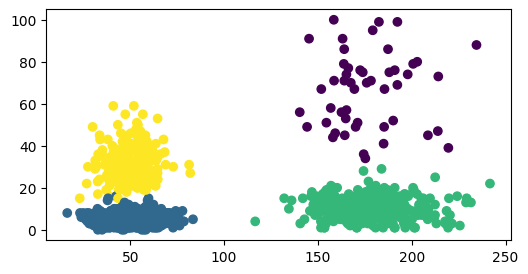

In [3]:
# Cargar dataset
D =cargar_dataset("dataset_cuatro_diferente_densidad.xlsx")
Dx = D[:,0:2]
Dy = D[:,2]
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy)

# 🎯 **:Cree el algoritmo K-means que tiene un único parámetro: el número de clústeres (K).**

In [4]:
# PASO 1 elejir los centros iniciales de forma randomica
def random_sample_float(n, mi, ma):
    return (ma - mi) * np.random.random_sample(n) + mi

def paso1_elije_centros(K, Dx):
  cDx = np.zeros(K*Dx.shape[1])
  cDx.shape = (K,Dx.shape[1])
  # 1.1 Completa el codigo aqui
  x1 = random_sample_float(K, np.min(Dx[:,0]), np.max(Dx[:,0]))
  x2 = random_sample_float(K, np.min(Dx[:,1]), np.max(Dx[:,1]))
  cDx[:,0] = x1
  cDx[:,1] = x2
  return cDx


Los centros iniciales elegidos aleatoriamente son:
[[ 63.41844333  31.9701101 ]
 [ 98.46979838  68.50561562]
 [202.27159801  37.39775613]
 [144.17425981  43.43446902]]


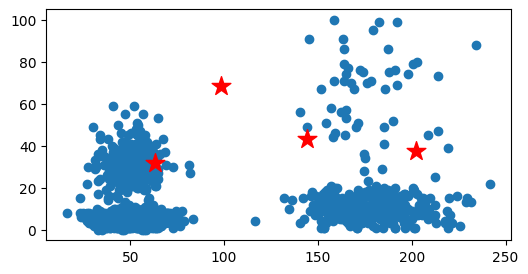

In [5]:
print('Los centros iniciales elegidos aleatoriamente son:')
K=4
cDx = paso1_elije_centros(K, Dx)
print(cDx)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1])
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

2.   Paso de asignación de datos
En este paso, cada elemento de nuestro dataset se asigna al centroide más cercano basado en la distancia escogida: en nuestro caso, la Euclidiana. Por tanto, tendremos que implementar la siguiente operación:

$$
\DeclareMathOperator*{\argminA}{arg\,min}
\argminA_{c_i \in C} dist\left ( c_i, x \right )^2
$$

In [6]:
# Definimos la distancia euclidiana de una instancia x con respecto a un grupo de instancias C
def distancia_euclidiana_grupo(x, C):
  return np.linalg.norm(C - x, axis=1);

def paso2_asigna_puntos(Dx, cDx):
  Dyp = np.zeros(Dx.shape[0])
  # Buscamos el centro más cercano a cada instancia y la asignamos a ese clúster
  for i in np.arange(Dx.shape[0]):
      # Tenemos que calcular la distancia de cada muestra del dataset Dx[i]
      # a cada centro existente en cDx. Podemos utilizar para ello la función
      # distancia_euclidiana_grupo.

      distancia_punto_a_centros = distancia_euclidiana_grupo(Dx[i],cDx ) # 1.2 Completa el codigo aqui

      # Una vez calculada la distancia, necesitamos averiguar el índice de
      # la distancia mínima. Para ello, podemos usar la función argmin de numpy.
      pred_y = np.argmin(distancia_punto_a_centros)
      Dyp[i] = pred_y
  return Dyp

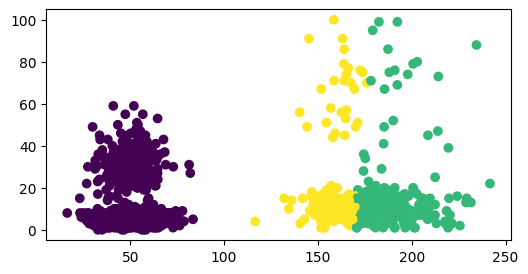

In [7]:
Dyp = paso2_asigna_puntos(Dx, cDx)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)

2.   Paso de actualización del centroide
En este paso se recalcula el centroide de cada cluster, teniendo en cuenta la nueva asignación calculada en el paso 1. Para ello, se calcula la media de todos los puntos asignados en el paso anterior.

$$
c_i = \frac{1}{\left | S_i \right |} \sum_{x_i \in S_i} x_i
$$


In [8]:
def paso3_actualiza_centros(Dx, cDx, Dyp, K):
  cDx_ant = cDx.copy()
  for k in range(K):
      # Seleccionamos los puntos asignados al cluster k
      puntos_cluster_k = Dx[Dyp == k]
      # Calculamos la media de las coordenadas x e y
      if len(puntos_cluster_k) > 0:  # Evitar división por cero si el cluster está vacío
          cDx[k,:] = np.mean(puntos_cluster_k, axis=0) # 1.3 Completa el codigo aqui
      else:
          # Si el cluster está vacío, mantenemos el centroide anterior
          cDx[k,:] = cDx_ant[k,:]
  return cDx

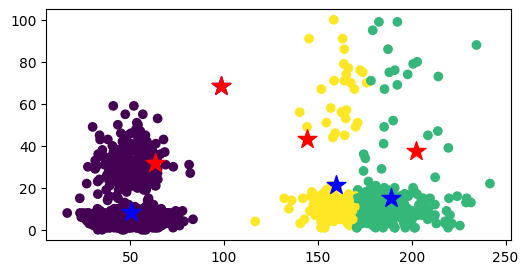

In [9]:
cDx_ant = cDx.copy()
cDx =paso3_actualiza_centros(Dx, cDx, Dyp, K)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='b')
ax.scatter(cDx_ant[:,0],cDx_ant[:,1], marker='*', s=200, c='r')

Y esto es todo. Este proceso se repite hasta cumplir un criterio de detención:

*   No hay cambios en los puntos asignados a cada cluster
*   La suma de las distancias alcanza un valor mínimo establecido
*   Se alcanza un número máximo de iteraciones

In [10]:
def MyKMeans(Dx, K):
  cDx = paso1_elije_centros(K, Dx) # 1.4 Completa el codigo aqui
  cDxIni = cDx.copy()
  # Flag de convergencia
  iterando = True
  while iterando:
    # Vector auxiliar para guardar los centros de la iteración pasada
    # necesarios para identificar la convergencia
    cDx_ant = cDx.copy()
    Dyp = paso2_asigna_puntos(Dx, cDx) # 1.5 Completa el codigo aqui
    # Calcular los nuevos centros
    #cDx = # 1.6 Completa el codigo aqui
    cDx =paso3_actualiza_centros(Dx, cDx, Dyp, K)
    iterando = (np.absolute(np.sum(cDx-cDx_ant)) > 0.00001)
  return cDx, Dyp, cDxIni

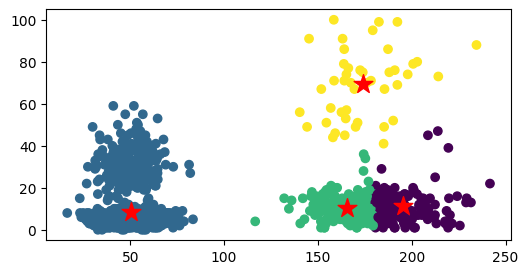

In [11]:
cDx, Dyp,cDxIni = MyKMeans(Dx, 4)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

# 🎯 **EJ 1: MODIFICA KMEANS PARA QUE SE CONVIERTA EN KMEANS++**

In [19]:
def distancia_euclidiana(a, b):
  return np.sqrt(np.sum((a - b) ** 2, axis=1))

def paso1_elije_centros_inteligente(K, Dx):
  cDx = np.zeros(K*Dx.shape[1])
  cDx.shape = (K,Dx.shape[1])

  # Paso 1: Primer centroide aleatorio,se elige aleatoriamente
  #        un punto de datos como primer centroide.
  n_samples, n_features = Dx.shape
  first_idx = np.random.randint(n_samples)
  cDx[0] = Dx[first_idx]

  # Pasos 2-4: Elegir centroides restantes
  for k in range(1, K):
      # Calcular distancias al centroide más cercano
      distances = np.zeros(n_samples)
      for i in range(n_samples):
          # Distancias del punto i a todos los centroides existentes
          point = Dx[i]
          dist_to_centroids = distancia_euclidiana(
              cDx[:k],
              np.tile(point, (k, 1))
          )
          # Guardar la distancia mínima

          # 1.1 Completa tu codigo aqui
          distances[i] = np.min(dist_to_centroids)

      # Convertir distancias a probabilidades
      probabilities = distances ** 2
      probabilities /= probabilities.sum()

      # Elegir siguiente centroide basado en probabilidades
      next_idx =  np.random.choice(n_samples, p=probabilities)# 1.1 Completa tu codigo aqui
      cDx[k] = Dx[next_idx]
  return cDx

In [20]:
def MyKMeansPlusPlus(Dx, K):
  cDx = paso1_elije_centros_inteligente(K, Dx)
  # 1.3 Completa el codigo aqui
  cDxIni = cDx.copy()
  # Flag de convergencia
  iterando = True
  while iterando:
    # Vector auxiliar para guardar los centros de la iteración pasada
    # necesarios para identificar la convergencia
    cDx_ant = cDx.copy()
    Dyp = paso2_asigna_puntos(Dx, cDx)
     # 1.4 Completa el codigo aqui
    # Calcular los nuevos centros
    cDx = paso3_actualiza_centros(Dx, cDx, Dyp, K)
    # 1.5 Completa el codigo aqui
    iterando = (np.absolute(np.sum(cDx-cDx_ant)) > 0.00001)
  return cDx, Dyp, cDxIni

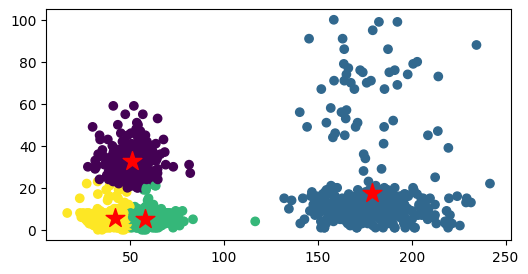

In [21]:
cDx, Dyp,cDxIni = MyKMeansPlusPlus(Dx, 4)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

# 🎯 **EJ 2: USA EL METODO DEL CODO CON KMEANS++ PARA DETERMINAR EL MEJOR K**
<hr>
<h2>Elegir el mejor valor de K</h2>

Para elegir el mejor valor de K se suele usar la técnica del codo. Ésta consiste en probar diferentes valores de K y evaluar el agrupamientos según alguna medida de evaluación intrínseca (ya que se supone que no se conoce la verdad básica). En este ejemplo, se usan dos medidas diferentes: la medida de Silueta y la R cuadrado.


In [22]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

In [23]:
def medida_R_cuadrado(X, Xyp, cXs):
    # Calcular SST (Suma Total de Cuadrados)
    centro_global = np.mean(X, axis=0)
    SST = np.sum(np.sum((X - centro_global)**2, axis=1))
    # Calcular SSE (Suma de Cuadrados del Error)
    SSE = 0
    for i in range(len(X)):
        # Encontrar el centroide correspondiente para cada punto
        cluster_label = int(Xyp[i])
        centroide = cXs[cluster_label]
        SSE += np.sum((X[i] - centroide)**2)

    # Calcular R²
    if SST == 0:
        return 1.0
    R_cuadrado = 1 - (SSE / SST)
    return R_cuadrado

Text(0, 0.5, 'Medida de R cuadrado')

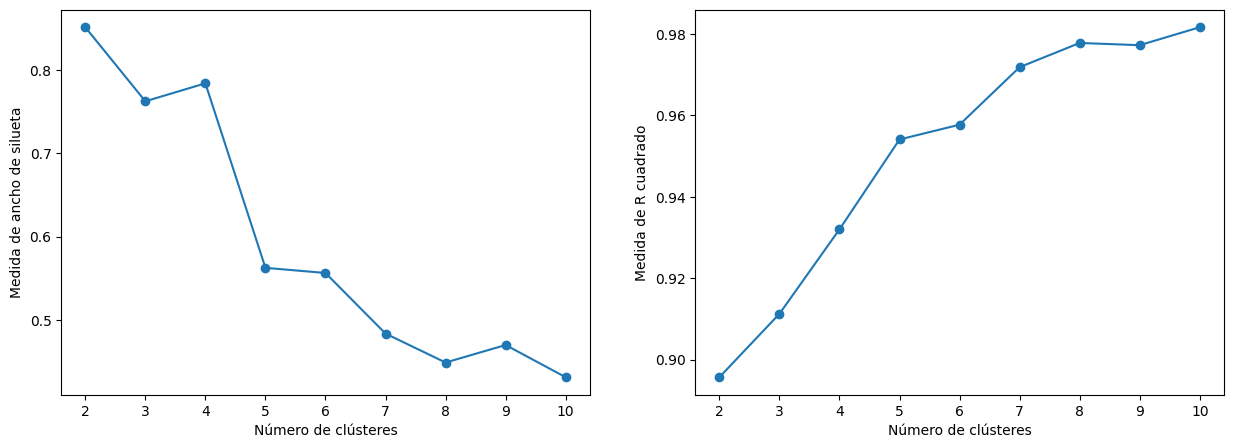

In [24]:
#METODO DEL CODO
# voy a probar para valores de k desde 2 al 11
rsilueta = np.zeros(9)
rrsquare = np.zeros(9)
for k in np.arange(2,11):
    cDx, Dyp,cDxIni = MyKMeansPlusPlus(Dx, k)
    rsilueta[k-2] = silhouette_score(Dx, Dyp) # 2.1 Completa el codigo aqui
    rrsquare[k-2] = medida_R_cuadrado(Dx, Dyp, cDx) # 2.2 Completa el codigo aqui

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot( np.arange(2,11),rsilueta, linestyle='-', marker='o')
ax[0].set_xlabel("Número de clústeres")
ax[0].set_ylabel("Medida de ancho de silueta")

ax[1].plot( np.arange(2,11),rrsquare, linestyle='-', marker='o')
ax[1].set_xlabel("Número de clústeres")
ax[1].set_ylabel("Medida de R cuadrado")

Redacte una conclusión que analice los gráficos del método del codo y del coeficiente de silueta (y/o R²) para la selección del número de clusters (k). Indique cuál es el valor óptimo de k y fundamente su elección con base en la interpretación de dichos gráficos.

Conclusión: analizando el coeficiente de la solueta el valor mas alto del coeficiente es para k = 2 con un 0.85 aproximadamente, de igual forma se puede observar que para k = 4 tambien tenemos un valor optimo de 0.78 aproximadamente lo cual nos indica que 4 cluster estan tambien bastante definidos y separados. Por otro lado si analizamos la medida de R cuadrado podemos observar el mismo comportamiento a partir de k = 2 vemos un incremento en la grafica pero centrandonos en k = 4 podemos ver que el patron es similar al de ancho de silueta por lo que podemos decir que un k optimos es 4 ya que a partir de este valor los clusters no son tan definidos.

## Métricas disponibles en KMeans de scikit-learn
El objeto KMeans de scikit-learn proporciona varias métricas y atributos importantes para evaluar el clustering:


Text(0, 0.5, 'Medida de incercia')

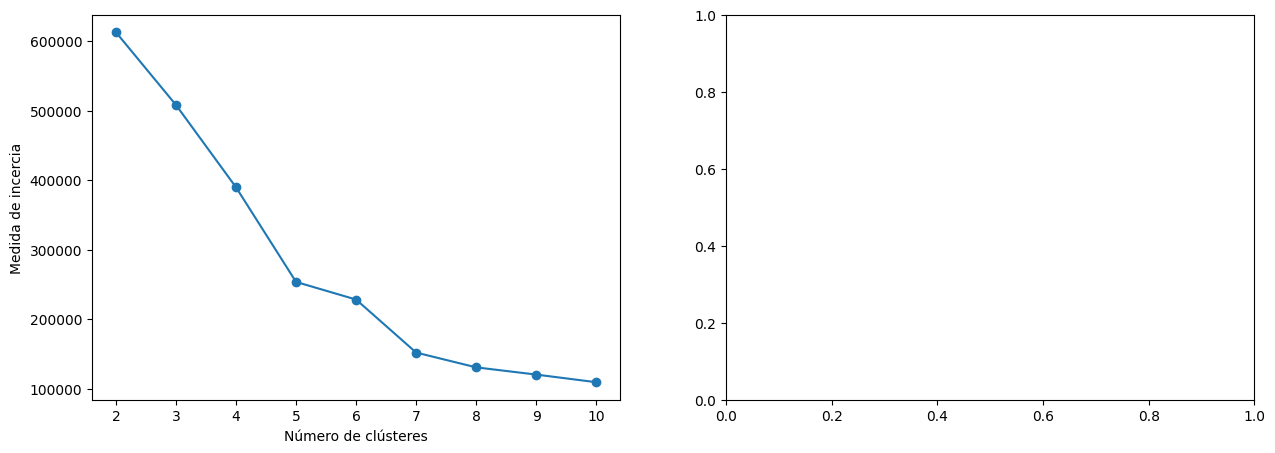

In [34]:
from sklearn.cluster import KMeans

rincercia = np.zeros(9)
for k in np.arange(2,11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(Dx)
    rincercia[k-2] =  kmeans.inertia_

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot( np.arange(2,11),rincercia, linestyle='-', marker='o')
ax[0].set_xlabel("Número de clústeres")
ax[0].set_ylabel("Medida de incercia")

Text(0.5, 1.0, 'Análisis de Calinski-Harabasz')

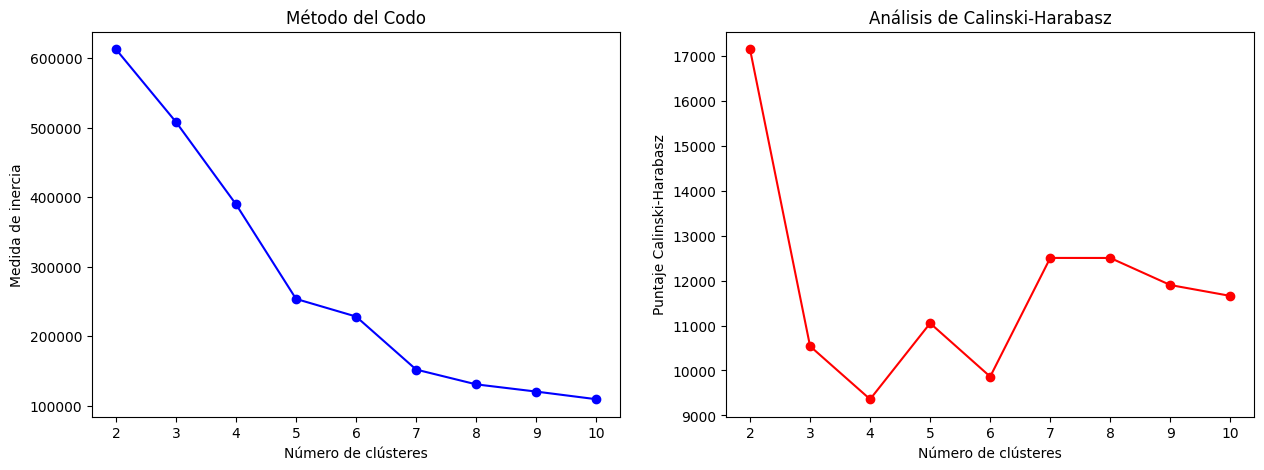

In [35]:
# 2.3 Complete el codigo anterior para graficar el indice de calinski
from sklearn.metrics import calinski_harabasz_score

rincercia = np.zeros(9)
calinski = np.zeros(9)

for k in np.arange(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(Dx)
    rincercia[k-2] = kmeans.inertia_
    calinski[k-2] = calinski_harabasz_score(Dx, kmeans.labels_)


fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico de la medida de Inercia
ax[0].plot(np.arange(2, 11), rincercia, linestyle='-', marker='o', color='b')
ax[0].set_xlabel("Número de clústeres")
ax[0].set_ylabel("Medida de inercia")
ax[0].set_title("Método del Codo")

# Gráfico de Calinski-Harabasz
ax[1].plot(np.arange(2, 11), calinski, linestyle='-', marker='o', color='r')
ax[1].set_xlabel("Número de clústeres")
ax[1].set_ylabel("Puntaje Calinski-Harabasz")
ax[1].set_title("Análisis de Calinski-Harabasz")

Redacte una conclusión comparativa basada en el gráfico de inercia (método del codo) y el índice de Calinski-Harabasz. Determine el número óptimo de clusters (k) e interprete cómo cada métrica justifica dicha selección.

Conclusión: analizando la grafica de metrica de calinski nos indica que apunta fuertemente a un k = 2 como el mejor candidato, es decir, que con k = 2 los clusters estan bien definidos, apesar de esto la medida de Inercia nos dice lo contrario como ya lo vimos en los graficos anteriores, un k = 4 o un k = 5, serian los mejores candidatos para el numero de clusters, si tomamos en cuenta a calinski podriamos decir que el mejor candidato seria k = 2, ya que en ambas metricas obtenemos clusters bien definidos para este k.

# 🎯 **EJ 3: USA EL SIGUIENTE DATASET CON KMEANS++**
Cargue el dataset dataset_cuatro_separables_peque y realice el siguiente análisis de agrupamiento (clustering):

Determinación del k óptimo: Utilice el algoritmo k-means para calcular y graficar el método del codo con un rango de k razonable (por ejemplo, de 2 a 15 clusters).

Selección: Con base en los gráficos, justifique y seleccione el número óptimo de clusters (k_optimo).

Modelo final: Ajuste un modelo final de k-means utilizando el k_optimo.

Visualización: Visualice los resultados del agrupamiento y que los puntos estén coloreados según el cluster asignado. Incluya los centroides en la visualización.

✅ Dataset cargado desde URL GitHub


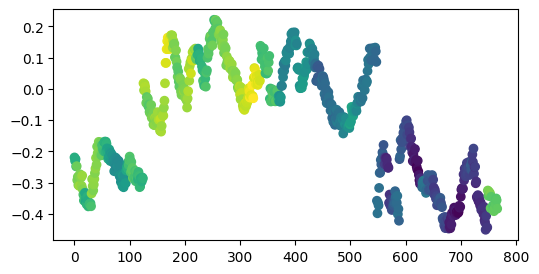

In [42]:
# Cargar dataset
D =cargar_dataset("dataset_cuatro_separables_peque.xlsx")
Dx = D[:,0:2]
Dy = D[:,2]
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy)

In [43]:
# PASO 1 elejir los centros iniciales de forma randomica
def random_sample_float_2(n, mi, ma):
    return (ma - mi) * np.random.random_sample(n) + mi

def paso1_elije_centros_2(K, Dx):
  cDx = np.zeros(K*Dx.shape[1])
  cDx.shape = (K,Dx.shape[1])
  # 1.1 Completa el codigo aqui
  x1 = random_sample_float(K, np.min(Dx[:,0]), np.max(Dx[:,0]))
  x2 = random_sample_float(K, np.min(Dx[:,1]), np.max(Dx[:,1]))
  cDx[:,0] = x1
  cDx[:,1] = x2
  return cDx


Los centros iniciales elegidos aleatoriamente son:
[[ 1.98066293e+02  1.15031678e-01]
 [ 2.31005030e+02 -3.80465602e-01]
 [ 7.31004860e+02 -4.10160671e-01]
 [ 6.86088272e+02 -2.76743463e-01]]


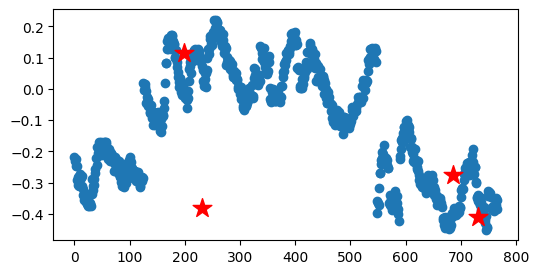

In [44]:
print('Los centros iniciales elegidos aleatoriamente son:')
K=4
cDx = paso1_elije_centros_2(K, Dx)
print(cDx)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1])
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

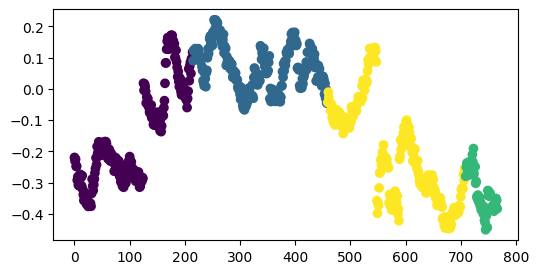

In [45]:
# Definimos la distancia euclidiana de una instancia x con respecto a un grupo de instancias C
def distancia_euclidiana_grupo_2(x, C):
  return np.linalg.norm(C - x, axis=1);

def paso2_asigna_puntos_2(Dx, cDx):
  Dyp = np.zeros(Dx.shape[0])
  # Buscamos el centro más cercano a cada instancia y la asignamos a ese clúster
  for i in np.arange(Dx.shape[0]):
      # Tenemos que calcular la distancia de cada muestra del dataset Dx[i]
      # a cada centro existente en cDx. Podemos utilizar para ello la función
      # distancia_euclidiana_grupo.

      distancia_punto_a_centros = distancia_euclidiana_grupo(Dx[i],cDx ) # 1.2 Completa el codigo aqui

      # Una vez calculada la distancia, necesitamos averiguar el índice de
      # la distancia mínima. Para ello, podemos usar la función argmin de numpy.
      pred_y = np.argmin(distancia_punto_a_centros)
      Dyp[i] = pred_y
  return Dyp

Dyp = paso2_asigna_puntos_2(Dx, cDx)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)

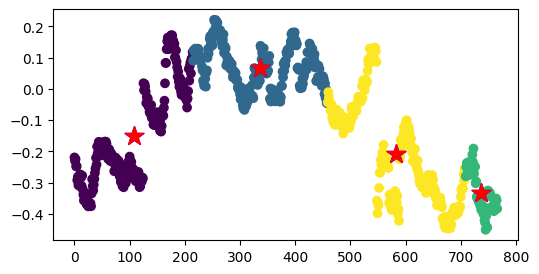

In [47]:
def paso3_actualiza_centros_2(Dx, cDx, Dyp, K):
  cDx_ant = cDx.copy()
  for k in range(K):
      # Seleccionamos los puntos asignados al cluster k
      puntos_cluster_k = Dx[Dyp == k]
      # Calculamos la media de las coordenadas x e y
      if len(puntos_cluster_k) > 0:  # Evitar división por cero si el cluster está vacío
          cDx[k,:] = np.mean(puntos_cluster_k, axis=0) # 1.3 Completa el codigo aqui
      else:
          # Si el cluster está vacío, mantenemos el centroide anterior
          cDx[k,:] = cDx_ant[k,:]
  return cDx

cDx_ant = cDx.copy()
cDx =paso3_actualiza_centros_2(Dx, cDx, Dyp, K)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='b')
ax.scatter(cDx_ant[:,0],cDx_ant[:,1], marker='*', s=200, c='r')

In [48]:
def distancia_euclidiana_2(a, b):
  return np.sqrt(np.sum((a - b) ** 2, axis=1))

def paso1_elije_centros_inteligente_2(K, Dx):
  cDx = np.zeros(K*Dx.shape[1])
  cDx.shape = (K,Dx.shape[1])

  # Paso 1: Primer centroide aleatorio,se elige aleatoriamente
  #        un punto de datos como primer centroide.
  n_samples, n_features = Dx.shape
  first_idx = np.random.randint(n_samples)
  cDx[0] = Dx[first_idx]

  # Pasos 2-4: Elegir centroides restantes
  for k in range(1, K):
      # Calcular distancias al centroide más cercano
      distances = np.zeros(n_samples)
      for i in range(n_samples):
          # Distancias del punto i a todos los centroides existentes
          point = Dx[i]
          dist_to_centroids = distancia_euclidiana(
              cDx[:k],
              np.tile(point, (k, 1))
          )
          # Guardar la distancia mínima

          # 1.1 Completa tu codigo aqui
          distances[i] = np.min(dist_to_centroids)

      # Convertir distancias a probabilidades
      probabilities = distances ** 2
      probabilities /= probabilities.sum()

      # Elegir siguiente centroide basado en probabilidades
      next_idx =  np.random.choice(n_samples, p=probabilities)
      cDx[k] = Dx[next_idx]
  return cDx

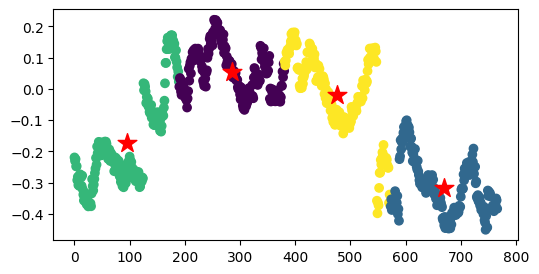

In [50]:
def MyKMeansPlusPlus(Dx, K):
  cDx = paso1_elije_centros_inteligente_2(K, Dx)
  # 1.3 Completa el codigo aqui
  cDxIni = cDx.copy()
  # Flag de convergencia
  iterando = True
  while iterando:
    # Vector auxiliar para guardar los centros de la iteración pasada
    # necesarios para identificar la convergencia
    cDx_ant = cDx.copy()
    Dyp = paso2_asigna_puntos_2(Dx, cDx)
     # 1.4 Completa el codigo aqui
    # Calcular los nuevos centros
    cDx = paso3_actualiza_centros_2(Dx, cDx, Dyp, K)
    # 1.5 Completa el codigo aqui
    iterando = (np.absolute(np.sum(cDx-cDx_ant)) > 0.00001)
  return cDx, Dyp, cDxIni


cDx, Dyp,cDxIni = MyKMeansPlusPlus(Dx, 4)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

## Elejir el mejor K

In [51]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

def medida_R_cuadrado_2(X, Xyp, cXs):
    # Calcular SST (Suma Total de Cuadrados)
    centro_global = np.mean(X, axis=0)
    SST = np.sum(np.sum((X - centro_global)**2, axis=1))
    # Calcular SSE (Suma de Cuadrados del Error)
    SSE = 0
    for i in range(len(X)):
        # Encontrar el centroide correspondiente para cada punto
        cluster_label = int(Xyp[i])
        centroide = cXs[cluster_label]
        SSE += np.sum((X[i] - centroide)**2)

    # Calcular R²
    if SST == 0:
        return 1.0
    R_cuadrado = 1 - (SSE / SST)
    return R_cuadrado

Text(0, 0.5, 'Medida de R cuadrado')

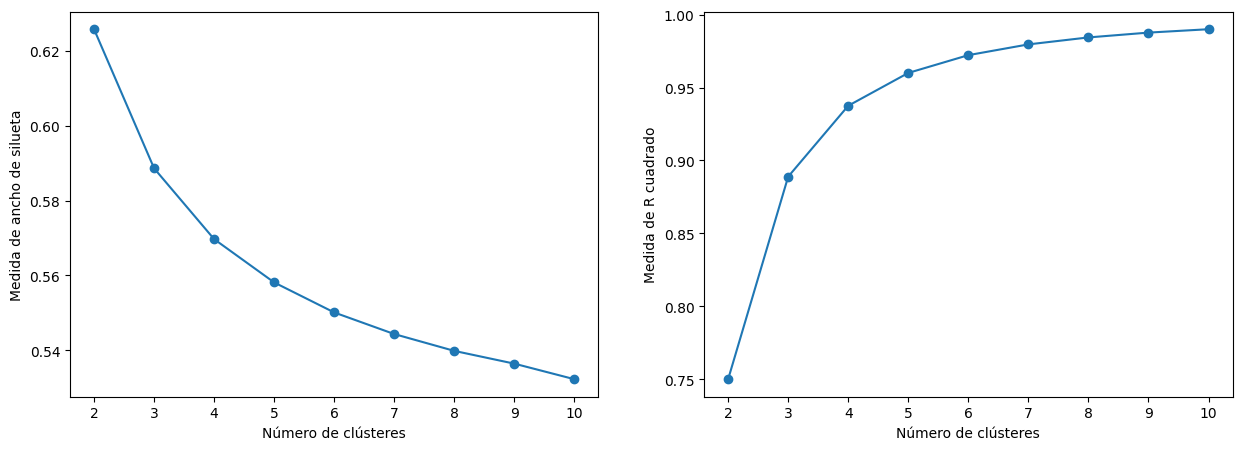

In [55]:
#METODO DEL CODO, RCUADRADO & CALINSKI
# voy a probar para valores de k desde 2 al 11
rsilueta = np.zeros(9)
rrsquare = np.zeros(9)
calinski = np.zeros(9)

for k in np.arange(2,11):
    cDx, Dyp,cDxIni = MyKMeansPlusPlus(Dx, k)
    rsilueta[k-2] = silhouette_score(Dx, Dyp)
    rrsquare[k-2] = medida_R_cuadrado(Dx, Dyp, cDx)

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot( np.arange(2,11),rsilueta, linestyle='-', marker='o')
ax[0].set_xlabel("Número de clústeres")
ax[0].set_ylabel("Medida de ancho de silueta")

ax[1].plot( np.arange(2,11),rrsquare, linestyle='-', marker='o')
ax[1].set_xlabel("Número de clústeres")
ax[1].set_ylabel("Medida de R cuadrado")

Text(0.5, 1.0, 'Análisis de Calinski-Harabasz')

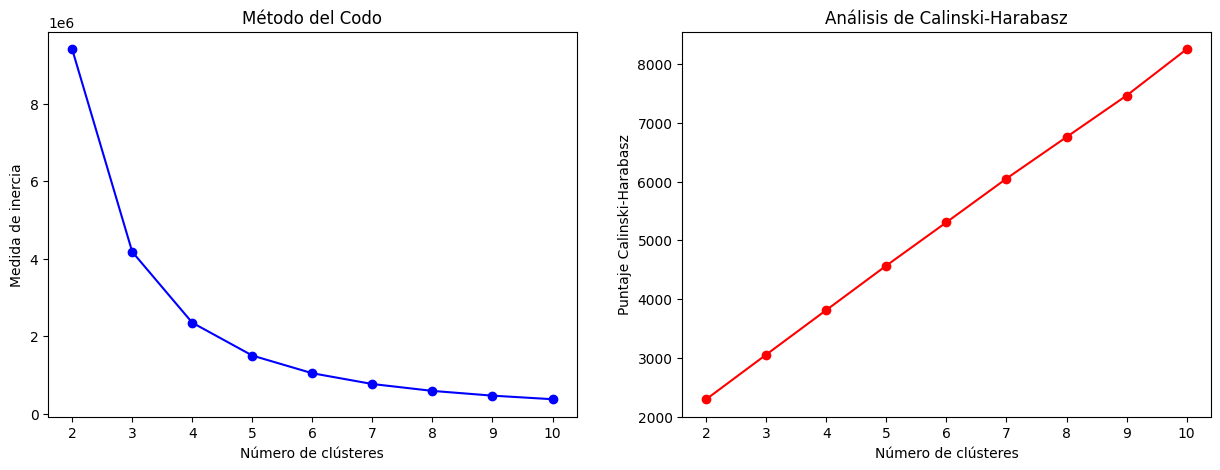

In [56]:
from sklearn.metrics import calinski_harabasz_score

rincercia = np.zeros(9)
calinski = np.zeros(9)

for k in np.arange(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(Dx)
    rincercia[k-2] = kmeans.inertia_
    calinski[k-2] = calinski_harabasz_score(Dx, kmeans.labels_)


fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico de la medida de Inercia
ax[0].plot(np.arange(2, 11), rincercia, linestyle='-', marker='o', color='b')
ax[0].set_xlabel("Número de clústeres")
ax[0].set_ylabel("Medida de inercia")
ax[0].set_title("Método del Codo")

# Gráfico de Calinski-Harabasz
ax[1].plot(np.arange(2, 11), calinski, linestyle='-', marker='o', color='r')
ax[1].set_xlabel("Número de clústeres")
ax[1].set_ylabel("Puntaje Calinski-Harabasz")
ax[1].set_title("Análisis de Calinski-Harabasz")

# 🚀 ¡TALLER FINALIZADO!"